<a href="https://colab.research.google.com/github/naenumtou/statisticalModel/blob/main/chainLadder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [2]:
# Import dataset
df = pd.read_csv('https://raw.githubusercontent.com/naenumtou/statisticalModel/main/datasets/PDCurves.csv')
df.head(5)

,Segment,Aging,Year,N,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,CU,0,2014,218263,0.000032,0.000133,0.000353,0.001874,0.003468,0.005200,0.007065,0.009053,0.011202,0.013511,0.015802,0.018116,0.020553,0.022913,0.025346,0.027691,0.030028,0.032291,0.034619,0.036965,0.039278,0.041441,0.043516,0.045564,0.047562,0.049454,0.051250,0.052936,0.054457,0.056010,0.057577,0.059048,0.060496,0.061884,0.063277,0.064661,0.065971,0.067267,0.068440,0.069545,0.070562,0.071487,0.072298,0.073040,0.073778,0.074465,0.075075,0.075684,0.076225,0.076751,0.07721,0.077659,0.078117,0.078566,0.079006,0.079404,0.079775,0.080119,0.08043,0.08066
1,CU,0,2015,255698,0.000023,0.000063,0.000199,0.001623,0.003277,0.005143,0.007040,0.009108,0.011166,0.013375,0.015589,0.017865,0.020047,0.022311,0.024568,0.026817,0.029034,0.031252,0.033411,0.035558,0.037626,0.039648,0.041752,0.043759,0.045667,0.047521,0.049277,0.051072,0.052820,0.054381,0.055808,0.057165,0.058413,0.059527,0.060575,0.061623,0.062629,0.063591,0.064561,0.065491,0.066367,0.067224,0.068010,0.068784,0.069539,0.070251,0.070916,0.071436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CU,0,2016,299541,0.000037,0.000080,0.000484,0.001819,0.003479,0.005288,0.007174,0.009057,0.011044,0.013130,0.015253,0.017403,0.019600,0.021697,0.023756,0.025853,0.027866,0.029816,0.031702,0.033411,0.035104,0.036709,0.038195,0.039637,0.041106,0.042565,0.044034,0.045466,0.046868,0.048144,0.049302,0.050481,0.051582,0.052654,0.053679,0.054560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CU,0,2017,325631,0.000049,0.000126,0.000694,0.002024,0.003535,0.005239,0.007008,0.008869,0.010761,0.012588,0.014329,0.016132,0.017894,0.019666,0.021438,0.023124,0.024807,0.026469,0.028026,0.029573,0.031161,0.032706,0.034152,0.035411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CU,0,2018,326584,0.000043,0.000101,0.000545,0.001990,0.003647,0.005447,0.007288,0.009207,0.011213,0.013320,0.015423,0.017456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Define wide table weighted average function
def weightedAverage(data):
  averageResult = []
  for i in data.columns[4:]:
    selectData = data[['Segment', 'Aging', 'N', i]].dropna() #Drop missing PD
    average = selectData.groupby(['Segment', 'Aging']).apply(lambda x: np.average(x[i], weights = x['N']))
    average = average.rename(i)
    averageResult.append(average)
  averageResult = pd.concat(averageResult, axis = 1).reset_index()
  averageResult['N'] = list(data.groupby(['Segment', 'Aging'])['N'].sum()) #Get total number by segment
  cols = averageResult.columns
  cols = cols[0:2].append(cols[-1:]).append(cols[2:-1]) #Rearrange columns
  averageResult = averageResult[cols]
  return averageResult

# Defind plot function
def plotPD(data):
  #Data creation
  for segment in data['Segment'].unique():
    selectData = data[data['Segment'] == segment]
    selectData = selectData.drop(['N'], axis = 1)
    selectData = pd.melt(selectData,
                         id_vars = ['Segment', 'Aging'],
                         var_name = 'times',
                         value_name = 'badRate')
    selectData['times'] = selectData['times'].astype(np.int8) #For better plot
    selectData = selectData.sort_values(by = ['Aging', 'times'])

    #Plot creation
    plt.figure(figsize = (10, 6))
    with plt.style.context('seaborn'):
      ax = sns.lineplot(x = 'times',
                        y = 'badRate',
                        data = selectData,
                        hue = 'Aging',
                        legend = 'full',
                        palette = 'viridis',
                        ci = None)
      ax.set_title(f'Cumulative PD: {segment}')
      ax.set(xlabel = 'Time', ylabel = 'PD')
  return plt.show()

In [4]:
# Weighted average PD by RAW data
averagePD = weightedAverage(df)
averagePD.head(5)

,Segment,Aging,N,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,CU,0,1425717,0.000038,0.000100,0.000475,0.001878,0.003492,0.005274,0.007121,0.009057,0.011064,0.013152,0.015225,0.017317,0.019388,0.021480,0.023574,0.025634,0.027661,0.029650,0.031589,0.033479,0.035351,0.037147,0.038882,0.040521,0.044436,0.046147,0.047803,0.049427,0.050977,0.052425,0.053788,0.055108,0.056355,0.057531,0.058667,0.059745,0.064168,0.065284,0.066347,0.067358,0.068299,0.069187,0.069985,0.070744,0.071491,0.072192,0.072831,0.073392,0.076225,0.076751,0.077210,0.077659,0.078117,0.078566,0.079006,0.079404,0.079775,0.080119,0.080430,0.080660
1,CU,1,178034,0.000219,0.005308,0.024389,0.039318,0.052692,0.065308,0.077654,0.089410,0.100402,0.110501,0.120337,0.129436,0.135824,0.143903,0.151342,0.158481,0.165160,0.171265,0.177055,0.182551,0.187652,0.192717,0.197545,0.201950,0.204847,0.208745,0.212172,0.215235,0.218181,0.221146,0.223886,0.226321,0.228845,0.231083,0.233273,0.235139,0.229775,0.231554,0.233320,0.234776,0.236188,0.237541,0.238968,0.240174,0.241233,0.242160,0.242910,0.243601,0.221061,0.221731,0.222542,0.223269,0.223856,0.224443,0.224946,0.225449,0.225925,0.226400,0.226679,0.226987
2,CU,2,73212,0.015530,0.084890,0.120581,0.149743,0.176351,0.200158,0.220770,0.239005,0.255204,0.270447,0.283929,0.296085,0.300680,0.311197,0.320704,0.329182,0.336873,0.344187,0.350850,0.357240,0.363320,0.368716,0.373872,0.378770,0.385675,0.389864,0.393889,0.397706,0.400824,0.403965,0.406781,0.409573,0.412203,0.414879,0.417438,0.419789,0.414825,0.417183,0.419330,0.421477,0.423553,0.425384,0.426580,0.427847,0.429114,0.430241,0.431332,0.432388,0.409277,0.410022,0.410841,0.411362,0.411883,0.412553,0.412925,0.413372,0.413968,0.414563,0.415159,0.415680
3,CU,3,14363,0.431247,0.514865,0.567291,0.602660,0.631623,0.654320,0.672910,0.686347,0.699715,0.710645,0.718374,0.726102,0.727978,0.733641,0.738782,0.744358,0.749586,0.753594,0.758125,0.761697,0.764573,0.768406,0.770498,0.772240,0.758971,0.760859,0.762748,0.764164,0.766053,0.767115,0.768532,0.770184,0.771719,0.773489,0.774433,0.775142,0.756352,0.757614,0.758695,0.759236,0.759596,0.759777,0.760137,0.760497,0.760858,0.761218,0.761218,0.761398,0.694030,0.694859,0.695688,0.696517,0.696932,0.697347,0.698176,0.698590,0.699005,0.699005,0.699834,0.700249
4,HU,0,4232680,0.000043,0.000116,0.000359,0.001288,0.002352,0.003503,0.004713,0.005981,0.007269,0.008582,0.009907,0.011223,0.012462,0.013799,0.015141,0.016471,0.017790,0.019076,0.020338,0.021563,0.022754,0.023915,0.025035,0.026117,0.029028,0.030164,0.031268,0.032341,0.033375,0.034370,0.035302,0.036213,0.037097,0.037944,0.038760,0.039521,0.044361,0.045181,0.045952,0.046678,0.047370,0.048023,0.048640,0.049229,0.049790,0.050311,0.050811,0.051255,0.056788,0.057276,0.057743,0.058185,0.058612,0.059020,0.059402,0.059759,0.060085,0.060391,0.060679,0.060913


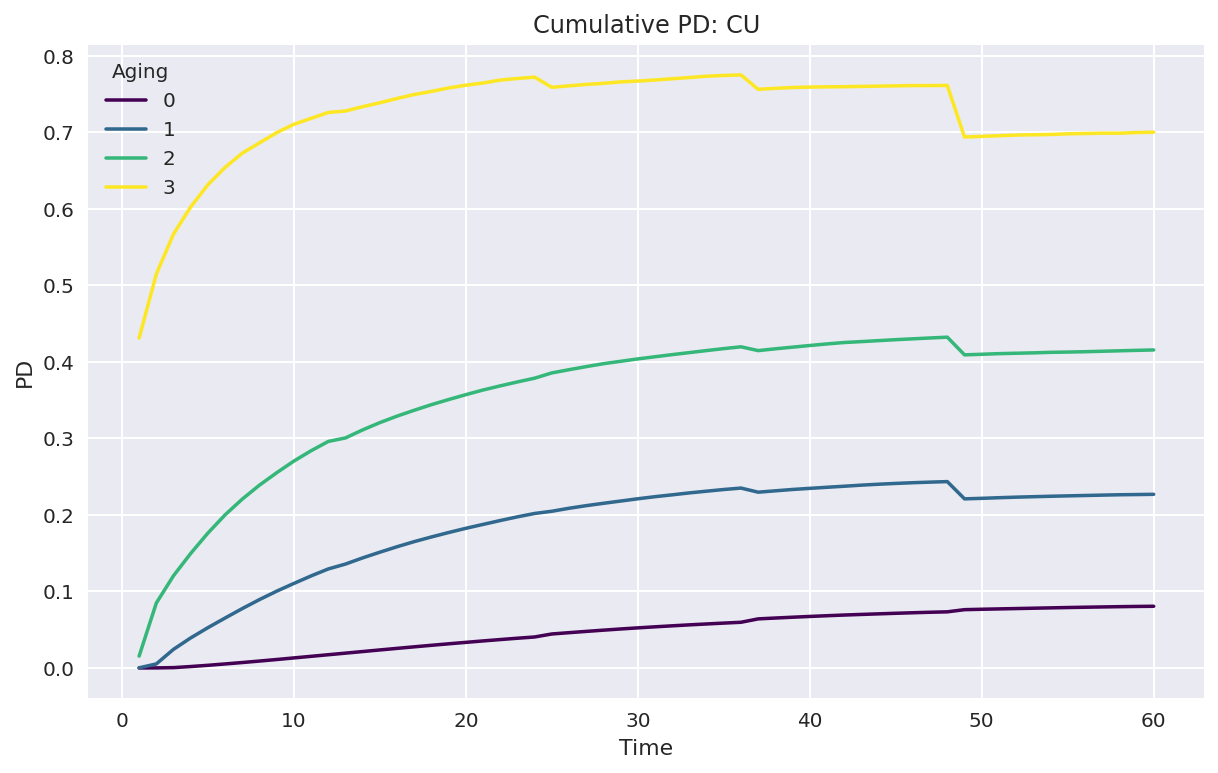

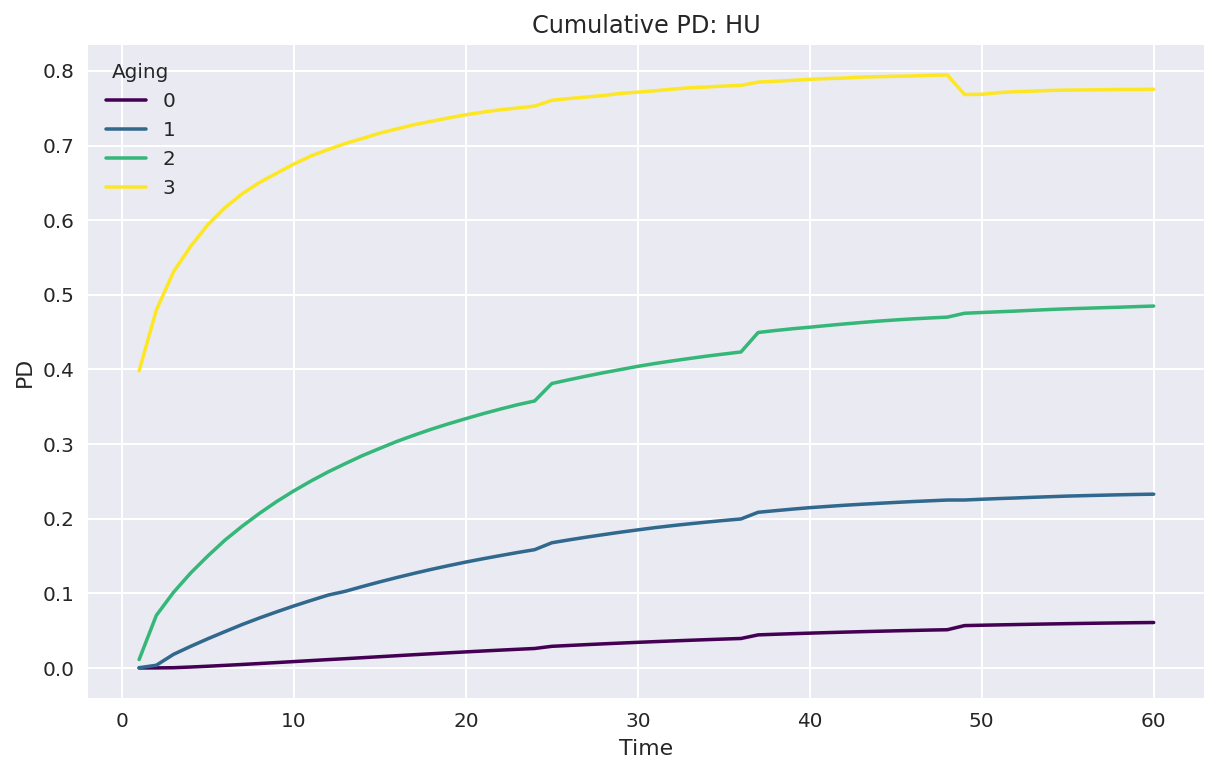

In [5]:
# Plot average PD by RAW data
plotPD(averagePD)

In [6]:
# Chain-ladder
# Calculate development factor
factors = []

for segment in df['Segment'].unique():
  for aging in df['Aging'].unique():

    # Calculate development factor by segment and risk grade
    data = df[(df['Segment'] == segment) & (df['Aging'] == aging)]
    data = data.drop(['Segment', 'Aging', 'Year'], axis = 1)

    for i in range(data.shape[1] - 1):

      # Break statement i can be maximum as 58 since forward data will be column 60
      if i > data.shape[1] - 3:
        break

      forward = data.iloc[:, i + 2] #Select forward time
      if forward.isnull().any() == True:
        current = data.iloc[0:forward.count(), i + 1] #Select current avaliable based on forward
        factor = np.nansum(forward * data.iloc[:, 0]) / np.nansum(current * data.iloc[:, 0]) #df[,:0] is number of observation
        factors.append(factor)
      else:
        pass #No missing value don't need to calculate factor

In [7]:
# Format shape of development factors
factors = np.array(factors)
factors = factors.reshape(df['Segment'].nunique() * df['Aging'].nunique(), -1) #Reshape by segment and risk grade

In [8]:
# Imputation with factors
dfChain = []

for s, segment in enumerate(df['Segment'].unique()):
  for a, aging in enumerate(df['Aging'].unique()):

    # Select data by segment and risk grade
    data = df[(df['Segment'] == segment) & (df['Aging'] == aging)]
    data = data.set_index(['Segment', 'Aging', 'Year', 'N']) #Set index to keep information

    # Select factor by segment and risk grade
    factor = factors[s * df['Aging'].nunique() + a] 

    for i in range(data.shape[1]):
      for j in range(data.shape[0]):
        if pd.isnull(data.iloc[j, i]):
          data.iloc[j, i] = data.iloc[j, i - 1] * factor[i - 12] #12 means the first 12 index do not need to be filled
          
        else:
          pass

    # Append result   
    dfChain.append(data)
  
dfChain = pd.concat(dfChain, axis = 0, ignore_index = False)
dfChain = dfChain.reset_index()
dfChain.head(5)

,Segment,Aging,Year,N,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,CU,0,2014,218263,0.000032,0.000133,0.000353,0.001874,0.003468,0.005200,0.007065,0.009053,0.011202,0.013511,0.015802,0.018116,0.020553,0.022913,0.025346,0.027691,0.030028,0.032291,0.034619,0.036965,0.039278,0.041441,0.043516,0.045564,0.047562,0.049454,0.051250,0.052936,0.054457,0.056010,0.057577,0.059048,0.060496,0.061884,0.063277,0.064661,0.065971,0.067267,0.068440,0.069545,0.070562,0.071487,0.072298,0.073040,0.073778,0.074465,0.075075,0.075684,0.076225,0.076751,0.077210,0.077659,0.078117,0.078566,0.079006,0.079404,0.079775,0.080119,0.080430,0.080660
1,CU,0,2015,255698,0.000023,0.000063,0.000199,0.001623,0.003277,0.005143,0.007040,0.009108,0.011166,0.013375,0.015589,0.017865,0.020047,0.022311,0.024568,0.026817,0.029034,0.031252,0.033411,0.035558,0.037626,0.039648,0.041752,0.043759,0.045667,0.047521,0.049277,0.051072,0.052820,0.054381,0.055808,0.057165,0.058413,0.059527,0.060575,0.061623,0.062629,0.063591,0.064561,0.065491,0.066367,0.067224,0.068010,0.068784,0.069539,0.070251,0.070916,0.071436,0.071946,0.072443,0.072876,0.073300,0.073732,0.074156,0.074571,0.074947,0.075298,0.075622,0.075916,0.076132
2,CU,0,2016,299541,0.000037,0.000080,0.000484,0.001819,0.003479,0.005288,0.007174,0.009057,0.011044,0.013130,0.015253,0.017403,0.019600,0.021697,0.023756,0.025853,0.027866,0.029816,0.031702,0.033411,0.035104,0.036709,0.038195,0.039637,0.041106,0.042565,0.044034,0.045466,0.046868,0.048144,0.049302,0.050481,0.051582,0.052654,0.053679,0.054560,0.055552,0.056518,0.057439,0.058314,0.059128,0.059897,0.060588,0.061245,0.061892,0.062498,0.063052,0.063538,0.063992,0.064434,0.064819,0.065196,0.065580,0.065957,0.066326,0.066661,0.066973,0.067261,0.067523,0.067715
3,CU,0,2017,325631,0.000049,0.000126,0.000694,0.002024,0.003535,0.005239,0.007008,0.008869,0.010761,0.012588,0.014329,0.016132,0.017894,0.019666,0.021438,0.023124,0.024807,0.026469,0.028026,0.029573,0.031161,0.032706,0.034152,0.035411,0.036875,0.038295,0.039669,0.041017,0.042303,0.043505,0.044636,0.045731,0.046766,0.047741,0.048684,0.049579,0.050480,0.051359,0.052195,0.052990,0.053730,0.054429,0.055057,0.055654,0.056242,0.056793,0.057296,0.057737,0.058150,0.058552,0.058901,0.059244,0.059593,0.059936,0.060271,0.060575,0.060858,0.061121,0.061358,0.061533
4,CU,0,2018,326584,0.000043,0.000101,0.000545,0.001990,0.003647,0.005447,0.007288,0.009207,0.011213,0.013320,0.015423,0.017456,0.019591,0.021705,0.023821,0.025902,0.027951,0.029960,0.031920,0.033830,0.035722,0.037536,0.039289,0.040946,0.042638,0.044280,0.045869,0.047427,0.048915,0.050304,0.051612,0.052878,0.054075,0.055203,0.056293,0.057328,0.058370,0.059385,0.060353,0.061272,0.062128,0.062936,0.063661,0.064352,0.065032,0.065669,0.066250,0.066761,0.067238,0.067703,0.068107,0.068503,0.068907,0.069303,0.069691,0.070043,0.070370,0.070673,0.070948,0.071150


In [9]:
# Weighted average PD by Chain-ladder imputation
averagePDChain = weightedAverage(dfChain)
averagePDChain.head(5)

,Segment,Aging,N,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,CU,0,1425717,0.000038,0.000100,0.000475,0.001878,0.003492,0.005274,0.007121,0.009057,0.011064,0.013152,0.015225,0.017317,0.019435,0.021531,0.023631,0.025695,0.027727,0.029721,0.031665,0.033559,0.035436,0.037236,0.038975,0.040618,0.042297,0.043926,0.045503,0.047048,0.048524,0.049902,0.051199,0.052455,0.053643,0.054762,0.055843,0.056870,0.057903,0.058911,0.059870,0.060782,0.061631,0.062433,0.063152,0.063838,0.064512,0.065144,0.065721,0.066227,0.066700,0.067161,0.067562,0.067955,0.068356,0.068749,0.069134,0.069483,0.069807,0.070108,0.070381,0.070581
1,CU,1,178034,0.000219,0.005308,0.024389,0.039318,0.052692,0.065308,0.077654,0.089410,0.100402,0.110501,0.120337,0.129436,0.138001,0.146209,0.153768,0.161020,0.167807,0.174010,0.179892,0.185476,0.190659,0.195805,0.200711,0.205186,0.209741,0.213732,0.217241,0.220377,0.223394,0.226430,0.229235,0.231728,0.234312,0.236604,0.238846,0.240756,0.242604,0.244484,0.246347,0.247885,0.249376,0.250805,0.252311,0.253585,0.254703,0.255681,0.256473,0.257203,0.258183,0.258966,0.259913,0.260762,0.261448,0.262133,0.262721,0.263309,0.263864,0.264419,0.264745,0.265104
2,CU,2,73212,0.015530,0.084890,0.120581,0.149743,0.176351,0.200158,0.220770,0.239005,0.255204,0.270447,0.283929,0.296085,0.307835,0.318602,0.328335,0.337015,0.344889,0.352377,0.359199,0.365740,0.371966,0.377490,0.382768,0.387783,0.392472,0.396734,0.400831,0.404715,0.407888,0.411085,0.413950,0.416791,0.419467,0.422190,0.424795,0.427187,0.430033,0.432477,0.434703,0.436929,0.439082,0.440979,0.442219,0.443533,0.444846,0.446014,0.447145,0.448240,0.449384,0.450202,0.451101,0.451673,0.452246,0.452981,0.453390,0.453881,0.454535,0.455189,0.455843,0.456415
3,CU,3,14363,0.431247,0.514865,0.567291,0.602660,0.631623,0.654320,0.672910,0.686347,0.699715,0.710645,0.718374,0.726102,0.732856,0.738557,0.743732,0.749346,0.754609,0.758644,0.763205,0.766801,0.769696,0.773555,0.775661,0.777415,0.779476,0.781415,0.783355,0.784810,0.786749,0.787840,0.789295,0.790992,0.792568,0.794386,0.795356,0.796083,0.797033,0.798362,0.799502,0.800071,0.800451,0.800641,0.801021,0.801401,0.801781,0.802160,0.802160,0.802350,0.802350,0.803309,0.804268,0.805226,0.805705,0.806185,0.807143,0.807623,0.808102,0.808102,0.809061,0.809540
4,HU,0,4232680,0.000043,0.000116,0.000359,0.001288,0.002352,0.003503,0.004713,0.005981,0.007269,0.008582,0.009907,0.011223,0.012550,0.013896,0.015247,0.016586,0.017915,0.019209,0.020481,0.021714,0.022913,0.024083,0.025211,0.026300,0.027402,0.028475,0.029517,0.030529,0.031505,0.032445,0.033325,0.034184,0.035019,0.035819,0.036589,0.037308,0.038047,0.038750,0.039412,0.040034,0.040627,0.041188,0.041717,0.042222,0.042704,0.043150,0.043579,0.043960,0.044373,0.044754,0.045120,0.045465,0.045799,0.046117,0.046416,0.046694,0.046949,0.047188,0.047413,0.047596


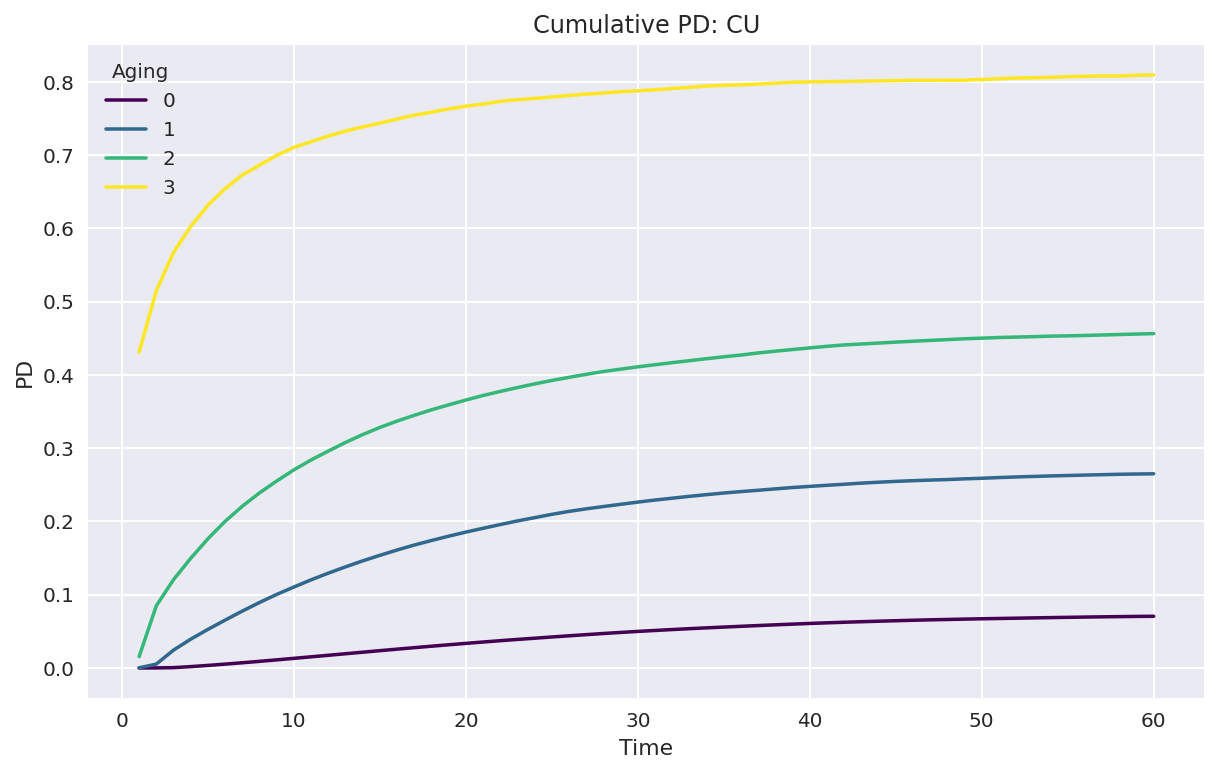

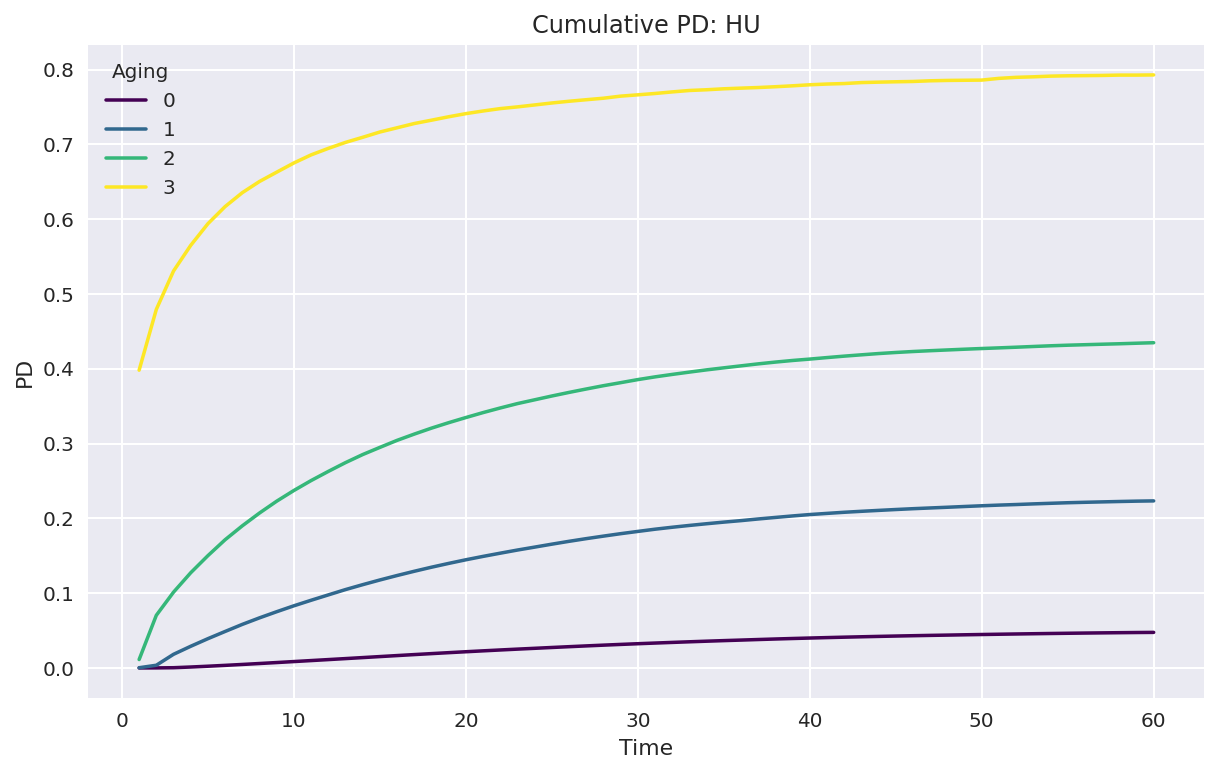

In [10]:
# Plot average PD by Chain-ladder imputation
plotPD(averagePDChain)

In [11]:
# Export result
dfChain.to_csv('PDYear.csv', index = 0)
averagePDChain.to_csv('PDRiskGrade.csv', index = 0)